In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# TensorFlow imports
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.utils import Sequence, to_categorical

from models.losses import Losses
from models.model import GMM_Survival
from utils.eval_utils import (accuracy_metric, calibration, cindex,
                              cindex_metric)
from utils.utils import ProgBar
tfd = tfp.distributions
tfkl = tf.keras.layers
tfpl = tfp.layers
tfk = tf.keras
# VaDeSC model

# Set Seaborn style for a cleaner look
sns.set(style="whitegrid")
print(os.getcwd())


# VaDeSC model


def setup_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


# Check for available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("Using GPU:", gpus[0].name)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
else:
    print("No GPU found. Using CPU.")

2024-02-01 16:22:52.288559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 16:22:52.385919: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


/m/home/home9/97/nguyenq10/unix/HUS/cancer-clusters
Using GPU: /physical_device:GPU:0


2024-02-01 16:22:58.607560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 16:22:58.636159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-01 16:22:58.636255: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
# from src.radcure import Radcure

from sklearn.model_selection import train_test_split
from auton_survival.preprocessing import Preprocessor


def del_multicol(df):
    return df.drop(columns=df.filter(regex='^N Stage_N[1-9X]').columns).drop(columns=["T Stage_T3/4", "Stage_III/IV", "ECOG_0"]) \
        .drop(columns=df.filter(regex='^Disease').columns).drop(columns="target_binary") \
        .drop(columns=["Sex_Female"])


# df_tr = Radcure.make_data("../data/radcure/clinical_train.csv")
# df_te = Radcure.make_data("/u/97/nguyenq10/unix/HUS/simpy-vadesc/data/radcure/clinical_test.csv")
df = pd.read_csv("./datasets/radcure/clinical_train.csv").drop(
    columns=["split", "target_binary", "Study ID"])
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.columns = [col.lower().strip() for col in df.columns]
display(df.head())

cat_feats = ["sex", "disease site", "t stage",
             "n stage", "hpv combined", "chemo?", "ecog", "stage"]
num_feats = ["age"]
outcomes = df[["death", "survival_time"]].rename(
    columns={"death": "event", "survival_time": "time"})
features = df.drop(columns=["death", "survival_time"])


preprocessor = Preprocessor(cat_feat_strat='ignore', num_feat_strat='mean')
x = preprocessor.fit_transform(features, cat_feats=cat_feats, num_feats=num_feats,
                               one_hot=True, fill_value=-1)
y = outcomes


x_tr, x_val, y_tr, y_val = train_test_split(
    x, y, test_size=0.3, random_state=1)

# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event'] == 1],
                    np.linspace(0.1, 1, 10)).tolist()
print(f'Number of training data points: {len(x_tr)}')
print(f'Number of validation data points: {len(x_val)}')
display(x.head())
display(y.head())

,age,sex,disease site,t stage,n stage,hpv combined,chemo?,ecog,stage,survival_time,death
0,66.7,male,larynx,t3,n0,NaN,0,0.0,iii,6.038356,0
1,68.4,female,hypopharynx,t2,n2b,NaN,0,1.0,iva,5.800000,0
2,49.7,female,nasopharynx,t1,n2,NaN,1,1.0,iii,7.556164,0
3,88.5,male,oropharynx,t2,n2a,NaN,0,2.0,iva,5.460274,0
4,69.8,male,oropharynx,t3,n2b,"yes, positive",0,0.0,iva,5.158904,0


Number of training data points: 1260
Number of validation data points: 540


,age,sex_male,disease site_hypopharynx,disease site_larynx,disease site_lip & oral cavity,disease site_nasal cavity,disease site_nasopharynx,disease site_oropharynx,disease site_paranasal sinus,disease site_salivary glands,...,ecog_4.0,stage_i,stage_ii,stage_iia,stage_iii,stage_iiia,stage_iiic,stage_iv,stage_iva,stage_ivb
0,0.397493,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0.541164,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,-1.039212,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,2.239856,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0.659480,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


,event,time
0,0,6.038356
1,0,5.800000
2,0,7.556164
3,0,5.460274
4,0,5.158904


## Vadesc

In [3]:
class DataGen(Sequence):
    def __init__(self, X, y):
        self.X = X.values
        self.y = y.values

    def __getitem__(self, index):
        return (self.X, self.y), {"output_1": self.X, "output_5": self.y}

    def __len__(self):
        return 1
    
# Assuming x_tr is your numpy array of training data
gen_tr = DataGen(x_tr, y_tr)
gen_val = DataGen(x_val, y_val)

(next(iter(gen_tr))[0][0].shape,next(iter(gen_tr))[0][1].shape, )

((1260, 45), (1260, 2))

In [4]:
from pprint import pprint
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer, B
from skopt.utils import use_named_args
from copy import deepcopy
from lifelines.utils import concordance_index
from auton_survival.metrics import survival_regression_metric
from vadesc import VaDeSC
import torch
from auton_survival.metrics import phenotype_purity

# Define the space of hyperparameters to search
space = [
    # Integer(2,2, name='k'),
    Real(1e-4, 5e-3, name='learning_rate'),
    # Categorical([[50, 100], [100], [100, 100], [32, 64]], name='layers'),
    Real(1.0, 3.0, name='weibull_shape'),
    Categorical(["True", "False"], name="sample_surv"),
    Integer(2, 16, name="latent_dim"),
    Categorical(["True", "False"], name="learn_prior"),
]

# Define the objective function
models = []
base_cfg = {"inp_shape": 45, "num_clusters": 2, "latent_dim": 16, 'monte_carlo': 1,
            'learn_prior': False, 'weibull_shape': 2.0, 'sample_surv': False,
            "activation": None, "survival": True, "epochs":1000}
# Define reconstruction loss function
loss = Losses(base_cfg).loss_reconstruction_mse

@use_named_args(space)
def objective(**params):
    cfg = deepcopy(base_cfg)
    for k, v in params.items():
        if k in cfg:
            cfg[k] = v
    print(cfg)
    # Construct the model & optimizer
    setup_seed(params["seed"])
    progress = ProgBar(epochs=cfg["epochs"],metrics=["loss","val_output_5_cindex_metric"])
    model = GMM_Survival(**cfg)
    tf.keras.backend.set_value(model.use_t, np.array([1.0]))
    optimizer = tf.keras.optimizers.legacy.Adam(
        learning_rate=params["learning_rate"], decay=0.00001)
    model.compile(optimizer, loss={"output_1": loss}, run_eagerly=True,
                  metrics={"output_5": cindex_metric})
    history = model.fit(gen_tr, validation_data=gen_val,
                        epochs=cfg["epochs"], verbose=0,
                        callbacks=[progress])
    print("loss", history.history['loss'][-1])
    rec, z_sample, p_z_c, p_c_z, risks, lambdas = model.predict((x_val.values, y_val.values))
    risks = np.squeeze(risks)
    phenotypes = np.argmax(p_c_z, -1)
    # Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val,
                                   phenotypes_test=None, outcomes_test=None,
                                   strategy='integrated', horizons=[6],
                                   bootstrap=None)

    # Return negative metric for minimization
    return np.mean(metric_val1)


# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event'] == 1],
                    np.linspace(0.1, 1, 10)).tolist()


# Run Bayesian optimization
result = gp_minimize(objective, space, n_calls=20, random_state=0)

# Extract the best parameters
best_params = {dim.name: result.x[i] for i, dim in enumerate(space)}

# Pair each set of parameters with its corresponding function value
params_and_func_vals = [(result.x_iters[i], result.func_vals[i])
                        for i in range(len(result.x_iters))]

# Sort the pairs based on the function value
sorted_params_and_vals = sorted(params_and_func_vals, key=lambda x: x[1])

# Get the top 5 best parameter sets
top_5_params = sorted_params_and_vals[:5]

print("Top 5 Best Parameters:")
for params, val in top_5_params:
    pprint({"params": params, "objective_value": val})

print("Best Parameters:", best_params)

# Train the model with the best parameters
best_cfg = deepcopy(base_cfg)
for k, v in best_params.items():
    if k == 'layers':
        best_cfg[k] = [int(layer)
                       for layer in v.split('-')]  # Convert string to list
    elif k in best_cfg:
        best_cfg[k] = v
best_model = VaDeSC(**best_cfg)
best_model.fit(x_tr, y_tr.time, y_tr.event, val_data=(x_val, y_val.time, y_val.event), iters=1200,
               learning_rate=best_params['learning_rate'], patience=800)
None
# You can now proceed to evaluate or use best_model as needed

ModuleNotFoundError: No module named 'skopt'

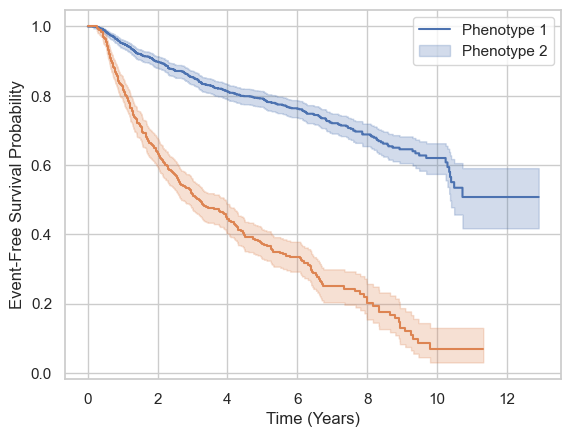

/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


array([0.18768911])

In [ ]:
import matplotlib.pyplot as plt
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
phe_tr = best_model.predict_latent_z(x_tr)
phe_val = best_model.predict_latent_z(x_val)
reporting.plot_kaplanmeier(y_val, groups=phe_val)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phe_val, outcomes_train=y_val, 
                          strategy='integrated', horizons=[6],
                          bootstrap=None)
metric

In [ ]:
# from copy import deepcopy
# from lifelines.utils import concordance_index
# from sklearn.model_selection import ParameterGrid
# from auton_survival.metrics import survival_regression_metric
# from vadesc import VaDeSC


# # Define parameters for tuning the model
# param_grid = {'k': [2, 3, 4],
#               'learning_rate': [1e-3],
#               'layers': [[50, 100], [100], [100, 100], [32, 64]],
#               'latent_dim': [8, 16],
#               'weibull_shape': [1.0, 1.5, 2.0],
#               'seed': [0, 1, 2]
#               }

# params = ParameterGrid(param_grid)

# # Define the times for tuning the model hyperparameters and for evaluating the model
# times = np.quantile(y_tr['time'][y_tr['event'] == 1],
#                     np.linspace(0.1, 1, 10)).tolist()
# # dflcfg = {'latent_dim': 16, 'activation': 'relu', 'monte_carlo': 1,
# #        'learn_prior': True, 'weibull_shape': 2, 'sample_surv': False}
# base_cfg = {"k": 2, "latent_dim": 16, 'activation': 'relu', 'monte_carlo': 1,
#             'learn_prior': True, 'weibull_shape': 2.0, 'sample_surv': False}
# # Perform hyperparameter tuning
# models = []
# for param in params:
#     cfg = deepcopy(base_cfg)
#     for k, v in param.items():
#         if k in cfg:
#             cfg[k] = v
#     model = VaDeSC(**cfg)

#     # The fit method is called to train the model
#     model.fit(x_tr, y_tr.time, y_tr.event, val_data=(x_val, y_val.time, y_val.event), iters=1000,
#               learning_rate=param['learning_rate'], patience=800)

#     # Obtain survival probabilities for validation set and compute the Integrated Brier Score
#     predictions_val = model.predict_survival(x_val, times)
#     # metric_val2 = survival_regression_metric('ctd', y_val, predictions_val, times, y_tr)
#     risk = model.predict_risks(x_val)
#     metric_val2 = concordance_index(y_val.time, risk, y_val.event)
#     metric_val1 = survival_regression_metric(
#         'ibs', y_val, predictions_val, times, y_tr)
#     models.append([metric_val1, metric_val2, model, param])

# # Select the best model based on the mean metric value computed for the validation set
# models = sorted(models, key=lambda x: x[1], reverse=True)
# model = models[0][2]
# print(models)

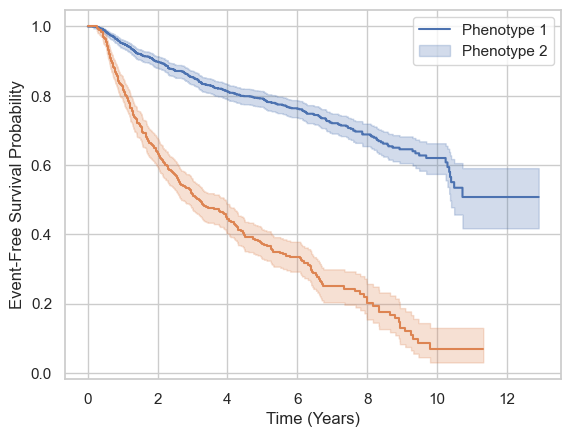

In [ ]:
from auton_survival import reporting
import matplotlib.pyplot as plt

# Estimate the probability of event-free survival for phenotypes using the Kaplan Meier estimator.
reporting.plot_kaplanmeier(outcomes, groups=phenotypes)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

Plotting the latent space...


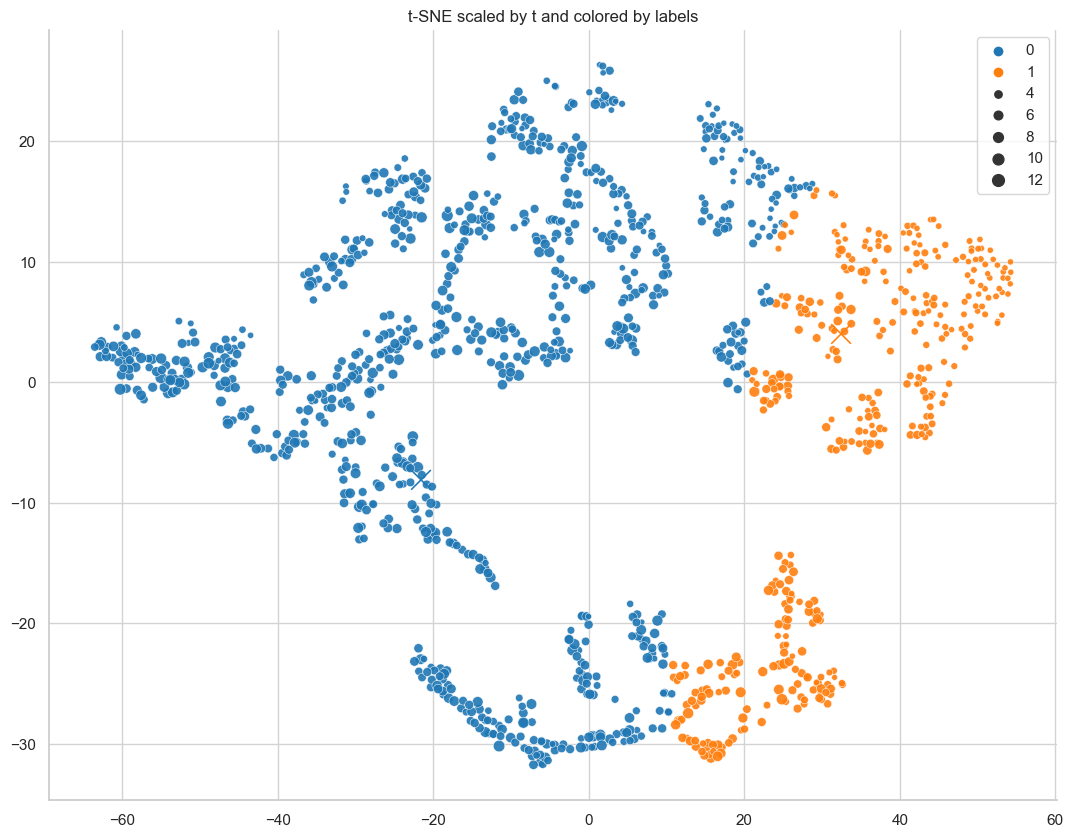

In [ ]:
from vadesc.vadesc_utilities import plot_latents_
import torch

plot_latents_(best_model.torch_model, x=torch.from_numpy(
    x_tr.values).double(), t=torch.from_numpy(y_tr.time.values).double())
None

In [ ]:
from vadesc.vadesc_utilities import predict_survival

predictions_val = best_model.predict_survival(x_val.values, y_val.time.values)
metric_val = survival_regression_metric(
    'ctd', y_val, predictions_val, times, y_tr)
metric_val

NameError: name 'best_model' is not defined

In [ ]:
from vadesc.vadesc_utilities import to_numpy, vadesc_step
from lifelines.utils import concordance_index
import torch

x_pred, p_c_z, risks, loss, losses = vadesc_step(best_model.torch_model, torch.from_numpy(x_val.values), loss=True, training=False)
c_index = concordance_index(y_val.time, to_numpy(risks), y_val.event)
c_index

NameError: name 'best_model' is not defined

## Deep Cox Mixtures

In [ ]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from copy import deepcopy
from lifelines.utils import concordance_index
from auton_survival.metrics import survival_regression_metric
from vadesc import VaDeSC
import torch
from auton_survival.metrics import phenotype_purity
from auton_survival.models.dcm import DeepCoxMixtures

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Define the space of hyperparameters to search
space = [
    # Integer(2,2, name='k'),
    Real(1e-4, 5e-3, name='learning_rate'),
    # Categorical([[50, 100], [100], [100, 100], [32, 64]], name='layers'),
    Categorical(['50-100', '100', '100-100', '32-64', '16-32'],
                name='layers'),  # Use strings
]

# Define the objective function
base_cfg = {'k': 2,
              'learning_rate': 1e-3,
              'layers': [100]}

@use_named_args(space)
def objective(**params):
    cfg = deepcopy(base_cfg)
    for k, v in params.items():
        if k == 'layers':
            cfg[k] = [int(layer)
                      for layer in v.split('-')]  # Convert string to list
        elif k in cfg:
            cfg[k] = v

    model = DeepCoxMixtures(**cfg)
    loss = model.fit(x_tr, y_tr.time, y_tr.event, val_data=(
        x_val, y_val.time, y_val.event), iters=1200, learning_rate=params['learning_rate'])

    phenotypes = np.argmax(model.predict_latent_z(x_val),axis=-1)
    # Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
    metric_val1 = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val,
                                   phenotypes_test=None, outcomes_test=None,
                                   strategy='integrated', horizons=[1, 2, 6],
                                   bootstrap=None)

    # Return negative metric for minimization
    print(metric_val1)
    return np.mean(metric_val1)


# Define the times for tuning the model hyperparameters and for evaluating the model
times = np.quantile(y_tr['time'][y_tr['event'] == 1],
                    np.linspace(0.1, 1, 10)).tolist()

base_cfg = {"k": 2}

# Run Bayesian optimization
result = gp_minimize(objective, space, n_calls=20, random_state=0)

# Extract the best parameters
best_params1 = {dim.name: result.x[i] for i, dim in enumerate(space)}

print("Best Parameters:", best_params1)

# Train the model with the best parameters
best_cfg = deepcopy(base_cfg)
for k, v in best_params1.items():
    if k == 'layers':
        best_cfg[k] = [int(layer)
                       for layer in v.split('-')]  # Convert string to list
    elif k in best_cfg:
        best_cfg[k] = v
best_model1 = DeepCoxMixtures(**best_cfg)
best_model1.fit(x_tr, y_tr.time, y_tr.event, val_data=(x_val, y_val.time, y_val.event), iters=1000,
               learning_rate=best_params1['learning_rate'])
None
# You can now proceed to evaluate or use best_model as needed

  0%|          | 0/1200 [00:00<?, ?it/s]

  4%|▍         | 49/1200 [00:01<00:44, 25.84it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03376256028479204, 0.07553776163884174, 0.15587728189116007]


  4%|▍         | 48/1200 [00:02<00:51, 22.58it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03283090336942276, 0.07219749181059437, 0.14683804821689542]


  2%|▏         | 18/1200 [00:00<00:47, 25.07it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03399850973770729, 0.07698235317467086, 0.15954555011341434]


  1%|▏         | 16/1200 [00:00<00:46, 25.37it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.0338511599625033, 0.07618974088030915, 0.15815454711901802]


  5%|▍         | 55/1200 [00:02<00:44, 25.70it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03399272705786183, 0.07684205824301873, 0.1589210829548822]


  1%|          | 8/1200 [00:00<00:51, 23.07it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationW

[0.03377296229156103, 0.07576314530750002, 0.15425259212446837]


  1%|▏         | 16/1200 [00:00<00:52, 22.72it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.032317784999622554, 0.06901856191813698, 0.13634328883088045]


  2%|▎         | 30/1200 [00:01<00:50, 23.23it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03259040305898764, 0.06985952511879168, 0.14112756265091977]


  1%|          | 8/1200 [00:00<00:48, 24.37it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationW

[0.03413774964841508, 0.07623926128541636, 0.1586658961094795]


  5%|▌         | 64/1200 [00:02<00:45, 24.99it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03238146947295677, 0.06896561903127123, 0.13429435345497615]


  5%|▍         | 55/1200 [00:02<00:45, 25.05it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03246746676089935, 0.06971864420702527, 0.13347717070264303]


  6%|▌         | 68/1200 [00:02<00:45, 24.95it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03248596242313196, 0.0702902465044537, 0.13604606291815846]


  6%|▌         | 69/1200 [00:02<00:47, 24.02it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.032545633497290616, 0.0702063977185939, 0.13807272684200717]


  2%|▏         | 25/1200 [00:01<00:48, 24.09it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03227671665146982, 0.0693840298211916, 0.13590832328540117]


  0%|          | 6/1200 [00:00<01:02, 19.17it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationW

[0.03399555426911699, 0.07691919518436996, 0.15922163040133772]


  4%|▍         | 50/1200 [00:02<00:47, 24.37it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03284376381432041, 0.07254406888010702, 0.1516303006329213]


  3%|▎         | 35/1200 [00:01<00:46, 25.28it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03338018129799653, 0.07470271577029167, 0.1538152666596546]


  1%|          | 13/1200 [00:00<00:48, 24.55it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: Approximation

[0.03394931994845749, 0.07652590537815894, 0.1580623054109033]


  7%|▋         | 88/1200 [00:03<00:42, 26.40it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.034002100361807244, 0.0770012255264213, 0.15959100694794054]


  0%|          | 6/1200 [00:00<01:03, 18.74it/s]
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationW

[0.03398598727486471, 0.0769829540995529, 0.15931264716821247]
Best Parameters: {'learning_rate': 0.0007877188240219614, 'layers': '32-64'}


  6%|▋         | 64/1000 [00:02<00:38, 24.51it/s]


In [ ]:
# from auton_survival.models.dcm import DeepCoxMixtures
# from auton_survival.metrics import survival_regression_metric
# from sklearn.model_selection import ParameterGrid

# # Define parameters for tuning the model
# param_grid = {'k': [2],
#               'learning_rate': [1e-3, 1e-4],
#               'layers': [[100], [100, 100],[50,100]]
#               }

# params = ParameterGrid(param_grid)

# # Define the times for tuning the model hyperparameters and for evaluating the model
# times = np.quantile(y_tr['time'][y_tr['event'] == 1],
#                     np.linspace(0.1, 1, 10)).tolist()

# # Perform hyperparameter tuning
# models = []
# for param in params:
#     model = DeepCoxMixtures(k=param['k'], layers=param['layers'],)

#     # The fit method is called to train the model
#     model.fit(x_tr, y_tr.time, y_tr.event, iters=100,
#               learning_rate=param['learning_rate'])

#     # Obtain survival probabilities for validation set and compute the Integrated Brier Score
#     predictions_val = model.predict_survival(x_val, times)
#     phenotypes = np.argmax(model.predict_latent_z(x_val),axis=-1)
#     # Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
#     metric_val3 = np.mean(phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
#                                     phenotypes_test=None, outcomes_test=None,
#                                     strategy='integrated', horizons=[1,2,6], 
#                                     bootstrap=None))
#     metric_val2 = survival_regression_metric(
#         'ctd', y_val, predictions_val, times, y_tr)
#     metric_val1 = survival_regression_metric(
#         'ibs', y_val, predictions_val, times, y_tr)
#     models.append([metric_val1, metric_val2, metric_val3, model, param])

# # Select the best model based on the mean metric value computed for the validation set
# models = sorted(models, key=lambda x: x[2], reverse=True)
# best_model = models[0][2]
# print(models)

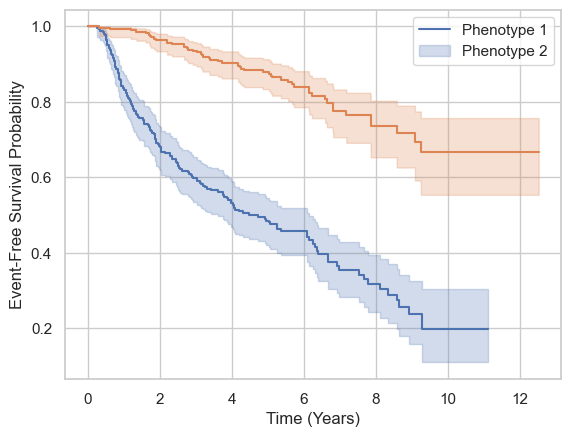

/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


[0.13429435345497615]

In [ ]:
from auton_survival.models.dcm.dcm_utilities import predict_latent_z

phe_val = np.argmax(best_model1.predict_latent_z(x_val.values), axis=-1)

# # Let's look at the phenotypes
# phenotypes = np.argmax(latent_z_prob, axis=-1)
# phenotypes

import matplotlib.pyplot as plt
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity

reporting.plot_kaplanmeier(y_val, groups=phe_val)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phe_val, outcomes_train=y_val, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='integrated', horizons=[6], 
                                bootstrap=None)
metric

In [ ]:
from auton_survival.phenotyping import ClusteringPhenotyper
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

# Perform dimensionality reduction using PCA
pca = PCA(n_components=8)
x_val1 = pca.fit_transform(x_val)

# Cluster x_val1 using Gaussian Mixture
gmm = GaussianMixture(n_components=2)
phenotypes = gmm.fit_predict(x_val1)

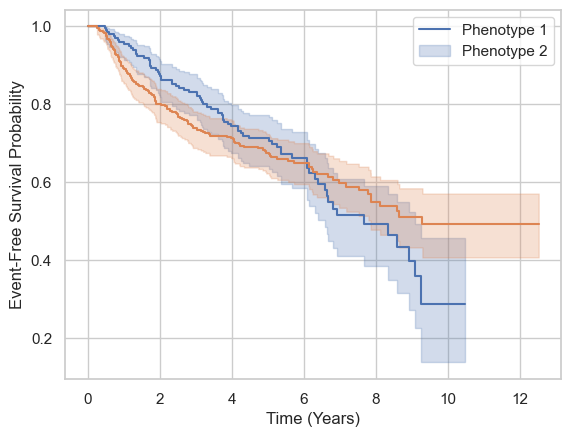

/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)
/u/97/nguyenq10/unix/myconda/.conda_envs/svdesc1/lib/python3.8/site-packages/lifelines/fitters/__init__.py:212: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


array([0.22600298])

In [ ]:
import matplotlib.pyplot as plt
from auton_survival import reporting
from auton_survival.metrics import phenotype_purity

reporting.plot_kaplanmeier(y_val, groups=phenotypes)

plt.xlabel('Time (Years)')
plt.ylabel('Event-Free Survival Probability')
plt.legend(['Phenotype 1', 'Phenotype 2'], loc="upper right")
plt.show()

# Estimate the Integrated Brier Score at event horizons of 1, 2 and 5 years
metric = phenotype_purity(phenotypes_train=phenotypes, outcomes_train=y_val, 
                                phenotypes_test=None, outcomes_test=None,
                                strategy='integrated', horizons=[6], 
                                bootstrap=None)
metric